# Monitoring vegetation with cloud-masked NDVI data

<b>Table of Contents</b>

- Overview
- Setup
- From idea to action: submitting point query
    - Sample data overview: key information from the table
- Constructing query & creating a cloud-free NDVI composite
    - Summary of the query
- Removing cloudy pixels
    - Classification labels for cloud detection and masking in satellite imagery
    - What do the numbers tell us
- Visualizing geospatial data: overlaying TIFF on a world map for interactive exploration

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Overview

In today’s rapidly changing environmental landscape, the ability to monitor and assess vegetation health is crucial for making informed decisions about agriculture, forestry, land management, and environmental protection. The Geospatial APIs query engine leverages high-resolution NDVI data from ESA Sentinel-2, combined with cloud masking techniques, to provide you with clear insights into vegetation health — whether you're tracking crop growth, assessing land condition, or monitoring environmental changes.

This following example application enables you to:

- <b>Monitor Vegetation Dynamics:</b> Gain insights into both <b>past and future vegetation conditions</b>, see changes over time and anticipate potential risks and opportunities.
- <b>Cloud-Free Data for Accurate Analysis:</b> The cloud masking ensures that your analysis is based on the most reliable data by removing cloud-contaminated pixels, offering you <b>clean, actionable NDVI values.</b>
- <b>Tailored to Your Needs:</b> Whether you are monitoring agricultural fields, forests, or urban areas, this customizable query adapts to your <b>specific area of interest (AOI)</b> and <b>temporal window</b>, providing you with the flexibility you need for detailed, localized analysis.

In [80]:
%pip install ibmpairs
%pip install rasterio
%pip install folium
%pip install configparser
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [81]:
# All imports needed for the sample
import configparser
import pandas as pd
import ibmpairs.client as client  # represents an authenticated HTTP client
import ibmpairs.query as query  # manages the submission of queries and retrieval of results
import os
import pandas as pd
import numpy as np
import PIL
from PIL import Image as img
import json
import datetime
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import Image


def now():
    return datetime.datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")


print(f"Current time: {now()}")
print("Imports initialized.")

Current time: 2024-12-31 09:32:13
Imports initialized.


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Setup

To get started with the Geospatial APIs SDK, follow the [installation](https://pages.github.ibm.com/physical-analytics/ibmpairs-internal/installation.html) instructions, then take a look at the [tutorials](https://pages.github.ibm.com/physical-analytics/ibmpairs-internal/tutorials/index.html).

**Note:** For the seamless execution of this notebook, kindly configure your Geospatial Analytics API credentials in a file named `secrets.ini`, following the prescribed format detailed below.

```
[EI]
api.host = https://api.ibm.com/geospatial/run/na/core/v4
api.api_key = <Your Geospatial Analytics API key>
api.tenant_id = <Your Geospatial Analytics Tenant ID>
api.org_id = <Your Geospatial Analytics Org ID>
```

Keep secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../../auth/secrets.ini')```

In [27]:
config = configparser.RawConfigParser()
config.read("../../../auth/secrets.ini")
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY = config.get("EI", "api.api_key")
EI_TENANT_ID = config.get("EI", "api.tenant_id")
EI_ORG_ID = config.get("EI", "api.org_id")

EI_client_v3 = client.get_client(
    api_key=EI_API_KEY,
    tenant_id=EI_TENANT_ID,
    org_id=EI_ORG_ID,
    legacy=False,
    version=3,
)

2024-12-10 03:43:11 - paw - INFO - The client authentication method is assumed to be OAuth2.
2024-12-10 03:43:11 - paw - INFO - Legacy Environment is False
2024-12-10 03:43:11 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2024-12-10 03:43:17 - paw - INFO - Authentication success.
2024-12-10 03:43:17 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Let's start by making a point query to retrieve NDVI values from the Geospatial API layer 49464, which features high-resolution imagery from the ESA Sentinel-2 dataset. We'll focus on a location in western region of USA, specifically the coordinates 37.12488 (latitude) and -122.28542 (longitude), which is near farmland.

This example will help us illustrate how NDVI can be used to monitor vegetation health over time.

We'll be querying data from January 5, 2020 to January 30, 2020 to explore how vegetation conditions changed over these days.

##### Why a point query?
Point queries are a great way to explore geospatial data when you're unsure about its spatial coverage, frequency, or temporal extent. In this case, by querying a specific location, we can examine detailed NDVI values for the area of interest.

Now, let's go ahead and define our query and submit it to retrieve the data!

### From idea to action: submitting point query

In [7]:
# Submit the query
query_result = query.submit(
    {
        "layers": [
            {"type": "raster", "id": "49464"},
            {"type": "raster", "id": "49362"},
        ],
        "spatial": {
            "type": "point",
            "coordinates": [
                "37.12488",
                "-122.28542",
            ],  # point in a farmland in western region of USA
        },
        "temporal": {
            "intervals": [
                {"start": "2020-01-05T00:00:00Z", "end": "2020-01-30T23:00:00Z"}
            ]
        },
    },
    client=EI_client_v3,
)
# Convert the results to a dataframe
point_df = query_result.point_data_as_dataframe()
# Convert the timestamp to a human readable format
point_df["datetime"] = pd.to_datetime(point_df["timestamp"] * 1e6, errors="coerce")
point_df["value"] = pd.to_numeric(point_df["value"], errors="coerce")
NDVI_df_pivot = point_df.pivot(
    index=["datetime", "longitude", "latitude"], columns=["layer_id"], values="value"
)
display(NDVI_df_pivot)

2024-12-05 09:59:32 - paw - INFO - TASK: submit STARTING.
2024-12-05 09:59:35 - paw - INFO - TASK: submit COMPLETED.


,,layer_id,49362,49464
datetime,longitude,latitude,,
2020-01-05,-122.28542,37.12488,4.0,0.9147
2020-01-10,-122.28542,37.12488,4.0,0.9302
2020-01-15,-122.28542,37.12488,9.0,0.0967
2020-01-20,-122.28542,37.12488,9.0,0.0143
2020-01-25,-122.28542,37.12488,8.0,0.3125
2020-01-30,-122.28542,37.12488,4.0,0.5936


### Sample data overview: key information from the table

<b>On January 20, the NDVI value is 0.0143:</b>
- <b>Scene Classification (Layer 49362):</b> The scene is classified as Cloud High Probability (9.0). This indicates a high likelihood of cloud cover in the area, which may be obscuring the ground surface. High cloud cover can affect the clarity of satellite imagery, leading to potential interference with vegetation detection.
- <b>NDVI (Layer 49464):</b> The NDVI value is 0.0143, which is very low, suggesting that there is very little to no vegetation at this location on this date. This could be a result of cloud cover obstructing the view of the ground or the area being naturally non-vegetated.
- <b>Implication:</b> On this day, the high cloud probability suggests that the satellite imagery may be affected by cloud cover, making it difficult to assess the true state of the vegetation. The low NDVI value further supports the idea that either the ground is not vegetated or cloud interference is limiting accurate vegetation detection.

<b>On January 25, the NDVI value drops to 0.3125:</b>
- <b>Scene Classification (Layer 49362):</b> The scene is classified as Cloud Medium Probability (8.0), indicating moderate cloud cover in the area. While clouds are still present, they are less obstructive than on January 20, allowing more visibility of the ground surface.
- <b>NDVI (Layer 49464):</b> The NDVI value is 0.3125, which shows moderate vegetation. This suggests that some vegetation is present, though it is not dense or lush. The moderate NDVI value indicates that the cloud cover on this date did not fully obscure the vegetation, providing a more accurate assessment of the land surface compared to January 20.
- <b>Implication:</b> On this day, the reduction in cloud cover compared to January 20 allowed a better view of the ground, and the moderate NDVI value reflects the presence of some vegetation. However, there may still be some cloud interference, which prevents a clearer or more detailed vegetation assessment.

<b>On January 30, the NDVI value rises to 0.5936:</b>
- <b>Scene Classification (Layer 49362):</b> The scene is classified as Vegetation (4.0), which indicates that the area is predominantly covered by vegetation. This suggests that the satellite imagery has accurately captured the ground conditions, showing healthy plant life in the region.
- <b>NDVI (Layer 49464):</b> The NDVI value is 0.5936, which indicates a significant presence of healthy vegetation. This is a relatively high NDVI value, suggesting that the area has a good amount of vegetation cover, and the conditions are favorable for plant growth.
- <b>Implication:</b> On this day, the absence of clouds (or minimal cloud interference) and the classification of the area as "vegetation" strongly support the presence of healthy plant life. The high NDVI value reflects a clear view of the vegetation, with minimal cloud interference, making it one of the clearest and most accurate observations of the area’s vegetation.


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Constructing query & creating a cloud-free NDVI composite

The following query defines a structured request for geospatial data that retrieves NDVI values (Normalized Difference Vegetation Index) over a specified time range and spatial area, while also applying cloud masking to the data to filter out cloud-contaminated pixels. The query is designed to handle both past and future NDVI data and process them accordingly.

In [37]:
# ======================================================================================================================================
# Utility functions for constructing a query that removes cloudy pixels on the fly by vectorizing the processing across multiple days.
# ======================================================================================================================================

iso8601 = "%Y-%m-%dT%H:%M:%SZ"
NO_DATA_VALUE = -9999


# The query_logic_1 function generates a conditional query string to evaluate a series of ndvi_data and cloud_condition values.
# For each index, it checks if both the ndvi_data and cloud_condition are non-null,
# and if the cloud_condition is between 3 and 7. If these conditions are met, the function returns the corresponding ndvi_data;
# otherwise, it returns a specified no_data_value.
def query_logic_1(n, i=0, no_data_value=NO_DATA_VALUE):
    if i + 1 >= n:
        return "($ndvi_data_{0} != null && $cloud_condition_{0} != null && $cloud_condition_{0} < 7 && $cloud_condition_{0} > 3) ? $ndvi_data_{0} : {1}".format(
            str(i).zfill(4), no_data_value
        )
    else:
        return "($ndvi_data_{0} != null && $cloud_condition_{0} != null && $cloud_condition_{0} < 7 && $cloud_condition_{0} > 3) ? $ndvi_data_{0} : ({1})".format(
            str(i).zfill(4), query_logic_1(n, i + 1)
        )


# The query_logic_2 function generates a conditional query string to evaluate cloud conditions across a series of indices.
# For each index, it checks if the cloud_condition_{i} is non-null and falls within the range of 3 to 7.
# If the condition is met, the function returns the range respective scene classification; otherwise, it returns a specified no_data_value
def query_logic_2(n, i=0, no_data_value=NO_DATA_VALUE):
    if i + 1 >= n:
        return "($cloud_condition_{0} != null && $cloud_condition_{0} < 7 && $cloud_condition_{0} > 3) ? {2} : {1}".format(
            str(i).zfill(4), no_data_value, i
        )
    else:
        return "($cloud_condition_{0} != null && $cloud_condition_{0} < 7 && $cloud_condition_{0} > 3) ? {2} : ({1})".format(
            str(i).zfill(4), query_logic_2(n, i + 1), i
        )


# The layer_part function creates a list of dictionaries representing two raster layers (NDVI data and cloud condition) for a specific index.
def layer_part(index, data_id, condition_id, q_time, output=True):
    layer_part = [
        {
            "alias": "ndvi_data_{0}".format(str(index).zfill(4)),
            "type": "raster",
            "id": data_id,
            "temporal": {
                "intervals": [
                    {
                        "start": (q_time).strftime(iso8601),
                        "end": (q_time).strftime(iso8601),
                    }
                ]
            },
            "output": False,
        },
        {
            "alias": "cloud_condition_{0}".format(str(index).zfill(4)),
            "type": "raster",
            "id": condition_id,
            "temporal": {
                "intervals": [
                    {
                        "start": (q_time).strftime(iso8601),
                        "end": (q_time).strftime(iso8601),
                    }
                ]
            },
            "output": False,
        },
    ]
    if output:
        layer_part[0]["output"] = True
        layer_part[1]["output"] = True
    return layer_part


# The build_query function constructs a query that outputs two raster images (final_composite_image and final_composite_image_control)
def build_query(AOI, data_id, condition_id, q_times):
    query_json = {
        "name": "cloudless_skies",
        "spatial": {"type": "square", "coordinates": AOI},
        "temporal": {
            "intervals": [
                {
                    "start": q_times.min().strftime(iso8601),
                    "end": q_times.max().strftime(iso8601),
                }
            ]
        },
    }

    layers = []
    for i in range(len(q_times)):
        layers.extend(layer_part(i, data_id, condition_id, q_times[i], output=(i == 0)))
    query_json["layers"] = layers

    query_json["layers"].extend(
        [
            {
                "alias": "final_composite_image",
                "expression": query_logic_1(len(q_times)),
                "output": True,
            },
            {
                "alias": "final_composite_image_control",
                "expression": query_logic_2(len(q_times)),
                "output": True,
            },
        ]
    )
    return query_json


print(f"Current time: {now()}")
print("Initialized utility functions for constructing a cloud-free query.")

Current time: 2024-12-09 22:19:45
Initialized utility functions for constructing a cloud-free query.


Next, let's define and submit a raster query to AGB Geospatial APIs covering a square area in the same farmland for a specific date in 2020 and analyze the result.

In [38]:
AOI = [37.12488, -122.28542, 37.15904, -122.26090]

query_timestamps = (
    pd.date_range(start="2020-01-10", end="2020-01-20", freq="D")
    .to_series()
    .sort_values(ascending=False)
)

queryJSON = build_query(AOI, "49464", "49362", query_timestamps)

print(f"Current time: {now()}")
print("Query JSON:")
print(json.dumps(queryJSON, indent=4))

Current time: 2024-12-09 22:19:48
Query JSON:
{
    "name": "cloudless_skies",
    "spatial": {
        "type": "square",
        "coordinates": [
            37.12488,
            -122.28542,
            37.15904,
            -122.2609
        ]
    },
    "temporal": {
        "intervals": [
            {
                "start": "2020-01-10T00:00:00Z",
                "end": "2020-01-20T00:00:00Z"
            }
        ]
    },
    "layers": [
        {
            "alias": "ndvi_data_0000",
            "type": "raster",
            "id": "49464",
            "temporal": {
                "intervals": [
                    {
                        "start": "2020-01-20T00:00:00Z",
                        "end": "2020-01-20T00:00:00Z"
                    }
                ]
            },
            "output": true
        },
        {
            "alias": "cloud_condition_0000",
            "type": "raster",
            "id": "49362",
            "temporal": {
                "inter

In [39]:
NDVIResult = query.submit_check_status_and_download(queryJSON, client=EI_client_v3)

2024-12-10 03:54:21 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2024-12-10 03:54:27 - paw - INFO - The query was successfully submitted with the id: 1733745600_37467166.
2024-12-10 03:54:31 - paw - INFO - The query 1733745600_37467166 has the status Initializing.
2024-12-10 03:55:05 - paw - INFO - The query 1733745600_37467166 has the status Running.
2024-12-10 03:55:39 - paw - INFO - The query 1733745600_37467166 has the status Succeeded.
2024-12-10 03:55:39 - paw - INFO - The query 1733745600_37467166 was successful after checking the status.
2024-12-10 03:56:14 - paw - INFO - The query 1733745600_37467166 has the status Succeeded.
2024-12-10 03:56:14 - paw - INFO - The query 1733745600_37467166 was successful after checking the status.
2024-12-10 03:56:14 - paw - INFO - The query download folder is set to the path /Users/raunakbhansali/Documents/GitHub/Environmental-Intelligence-internal/geospatial_analytics/v3_apis/samples/industry_use_cases/cloudfree_ndvi/downl

The query takes a few seconds to complete and downloads the output as a zip file in the /download folder, located in the same directory as this notebook. Now, let's display the resulting TIFF file and its summary using the following functions.

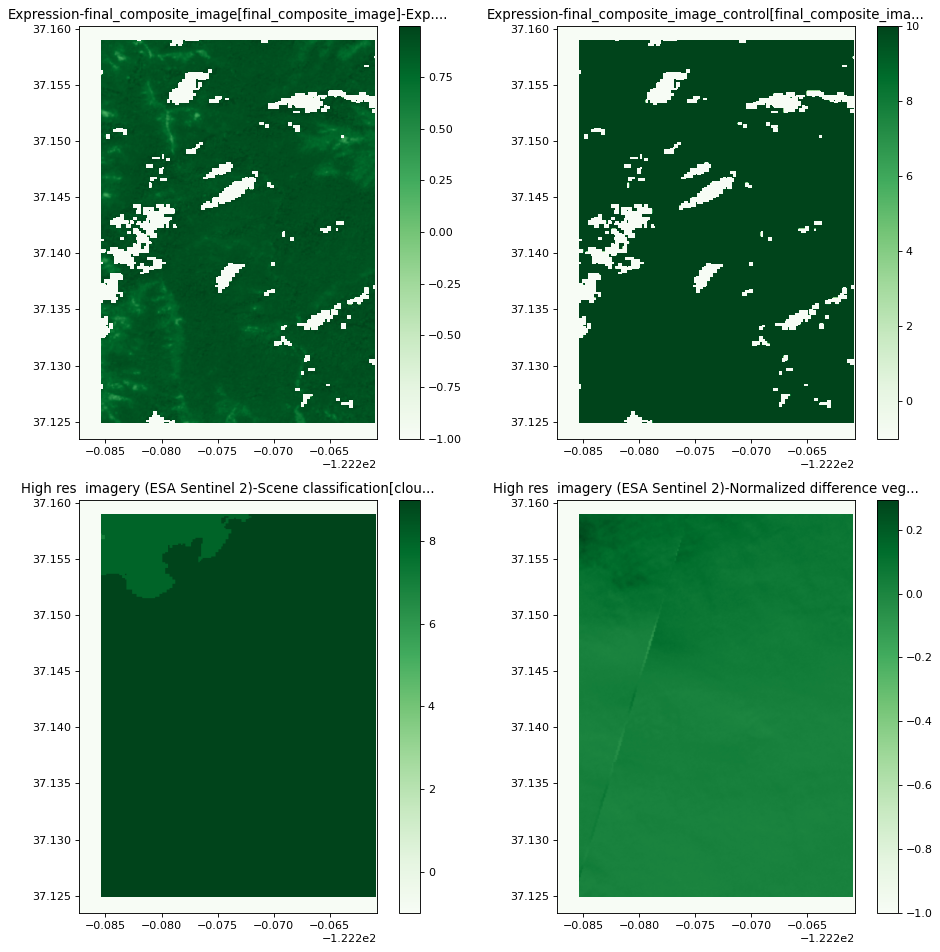

In [73]:
NDVIResult_File_List = NDVIResult.list_files()

num_columns = 2
num_rows = 2
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 12), dpi=80)
axes = axes.flatten()


# Function to shorten the filename
def shorten_filename(filename, max_length=60):
    base_name = os.path.basename(filename)
    if len(base_name) > max_length:
        return base_name[:max_length] + "..."
    return base_name


# Loop through each file and plot the corresponding image
image_index = 0
for file in NDVIResult_File_List:
    if file.endswith(".tiff"):  # Process only .tiff files
        with open(file + ".json", "r") as summary_file:
            fileparms = json.load(summary_file)

        boundingBox = fileparms["boundingBox"]
        myextent = [
            boundingBox["minLongitude"],
            boundingBox["maxLongitude"],
            boundingBox["minLatitude"],
            boundingBox["maxLatitude"],
        ]
        arrayNDMI = np.array(img.open(file))
        ax = axes[image_index]
        im = ax.imshow(arrayNDMI, cmap="Greens", vmin=-1, extent=myextent)
        ax.set_title(shorten_filename(file))
        fig.colorbar(im, ax=ax)
        image_index += 1

plt.tight_layout()
plt.show()

#### Summary of the query:
The query above retrieves data for multiple time intervals, including daily NDVI and cloud condition data, where the NDVI and cloud data are processed for each day. The final output includes a composite image, constructed using an expression that selects NDVI data for clear days (where cloud conditions fall within a specified range). The composite is generated by evaluating the cloud conditions for each day, and selecting the NDVI data accordingly, excluding days with significant cloud cover. The output is a final composite image representing vegetation health under cloudless or minimal cloud conditions during this period.

- <b>NDVI Layers:</b> Retrieves and processes NDVI data for each day within the defined temporal window.
- <b>Cloud Masking:</b> Filters out cloud-affected data by excluding days with significant cloud cover (based on cloud condition thresholds).
- <b>Composite Image:</b>
  - Constructs a final composite image that selects NDVI data for clear or minimally clouded days.
  - Provides a clearer representation of vegetation health during the specified period.
- <b>Output:</b> A cloud-masked NDVI composite reflecting vegetation health under cloudless or minimal cloud conditions.

Please note that the images provided are from January 10, 2020, onwards. While January 5th also showed relatively clear skies in the selected region, earlier dates might offer even clearer conditions. Therefore, users could consider looking back to the farthest date to create an image with a higher likelihood of finding non-cloudy pixels. However, due to data processing limitations in this preview, only a limited range of images can be provided.

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Removing cloudy pixels

In [74]:
# Function to display the resulting Tiff(s).
NDVIResult_File_List = NDVIResult.list_files()
for file in NDVIResult_File_List:
    if file.endswith(".tiff"):  # display the raster images
        with open(file + ".json", "r") as summary_file:
            fileparms = json.load(summary_file)
        arrayNDVI = np.array(PIL.Image.open(file))
        if ("control" in file) | ("classification" in file):
            arrayNDVI[arrayNDVI == -9999] = 0
            arrayNDVI[(arrayNDVI <= 7) & (arrayNDVI >= 0)] = (
                0  # set non-cloudy pixels to 0
            )
            arrayNDVI[(arrayNDVI >= 8) & (arrayNDVI <= 11)] = (
                1  # set cloudy pixels to 1
            )
            cloudy_sum = arrayNDVI.sum()
            print("cloudy pixel:", cloudy_sum, " for ", os.path.basename(file))

cloudy pixel: 194272.0  for  Expression-final_composite_image_control[final_composite_image_control]-Exp.tiff
cloudy pixel: 205016.0  for  High res  imagery (ESA Sentinel 2)-Scene classification[cloud_condition_0000]-01_20_2020T00_00_00.tiff


#### Classification labels for cloud detection and masking in satellite imagery

The numeric classification labels used in the conditional statements above to set non-cloudy pixels to 0 & cloudy pixels to 1 are as follows:

- **0 - NO_DATA**: These pixels represent areas with no data available, which could be due to missing or unrecorded information.

- **1 - SATURATED_OR_DEFECTIVE**: Pixels that are classified as saturated or defective indicate problematic sensor data or overexposed areas that are not useful for analysis.

- **2 - DARK_AREA_PIXELS**: Typically, these pixels represent areas with low reflectance, such as deep shadows or dark surfaces, which are not vegetation or water.

- **3 - CLOUD_SHADOWS**: Shadows cast by clouds on the surface, which can affect the analysis by altering the reflectance of underlying land features.

- **4 - VEGETATION**: Areas classified as vegetation cover, showing healthy or moderate plant growth. This is a key focus in agricultural and environmental studies.

- **5 - NOT_VEGETATED**: These regions are devoid of vegetation, such as barren land, rock, or urban areas.

- **6 - WATER**: Identifies water bodies like rivers, lakes, and oceans, which are critical for hydrological studies and environmental management.

- **7 - UNCLASSIFIED**: Pixels that couldn't be classified due to ambiguous or mixed land cover types.

- **8 - CLOUD_MEDIUM_PROBABILITY**: Areas that are likely to be clouds with medium probability, but the cloud coverage is not confirmed.

- **9 - CLOUD_HIGH_PROBABILITY**: High-confidence pixels identified as clouds, which are removed from analysis to ensure accurate vegetation or land cover classification.

- **10 - THIN_CIRRUS**: Represents thin, high-altitude cirrus clouds, which can be difficult to detect but may still affect surface measurements in some cases.

- **11 - SNOW**: Pixels classified as snow-covered areas, crucial for climate monitoring and seasonal assessments.

#### What do the numbers tell us:
The first image (High res  imagery (ESA Sentinel 2)-Scene classification[cloud_condition_0000]-01_20_2020T00_00_00) has 205,016 cloudy pixels.
The second image (Expression-final_composite_image_control[final_composite_image_control]-Exp.tiff) has 194,272 cloudy pixels.

<b>How this shows improvement:</b>

In the second image (Expression-final_composite_image_control[final_composite_image_control]-Exp.tiff), the number of cloudy pixels is significantly reduced — from 205,016 cloudy pixels in the first image to 194,272 cloudy pixels in the final composite image.
This means that the final image has about 5.23% fewer cloudy pixels compared to the initial image, which indicates a significant improvement in terms of cloud removal or reduction.

<b>What this improvement means:</b>

If you’re using these images for analysis or interpretation, the reduction in cloudy pixels is a good sign that the final composite image (Expression-final_composite_image_control.tiff) is much clearer and likely has more usable data. Fewer cloudy pixels mean fewer areas with obstructions, leading to a better overall image quality for any subsequent analysis (e.g., land cover classification, vegetation analysis, etc.).
This reduction in cloud coverage is especially useful in satellite imagery, where clouds often obscure the ground features you're interested in. The fact that the cloud cover has been reduced in the final image gives you more accurate and reliable data to work with.

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Visualizing geospatial data: overlaying TIFF on a world map for interactive exploration

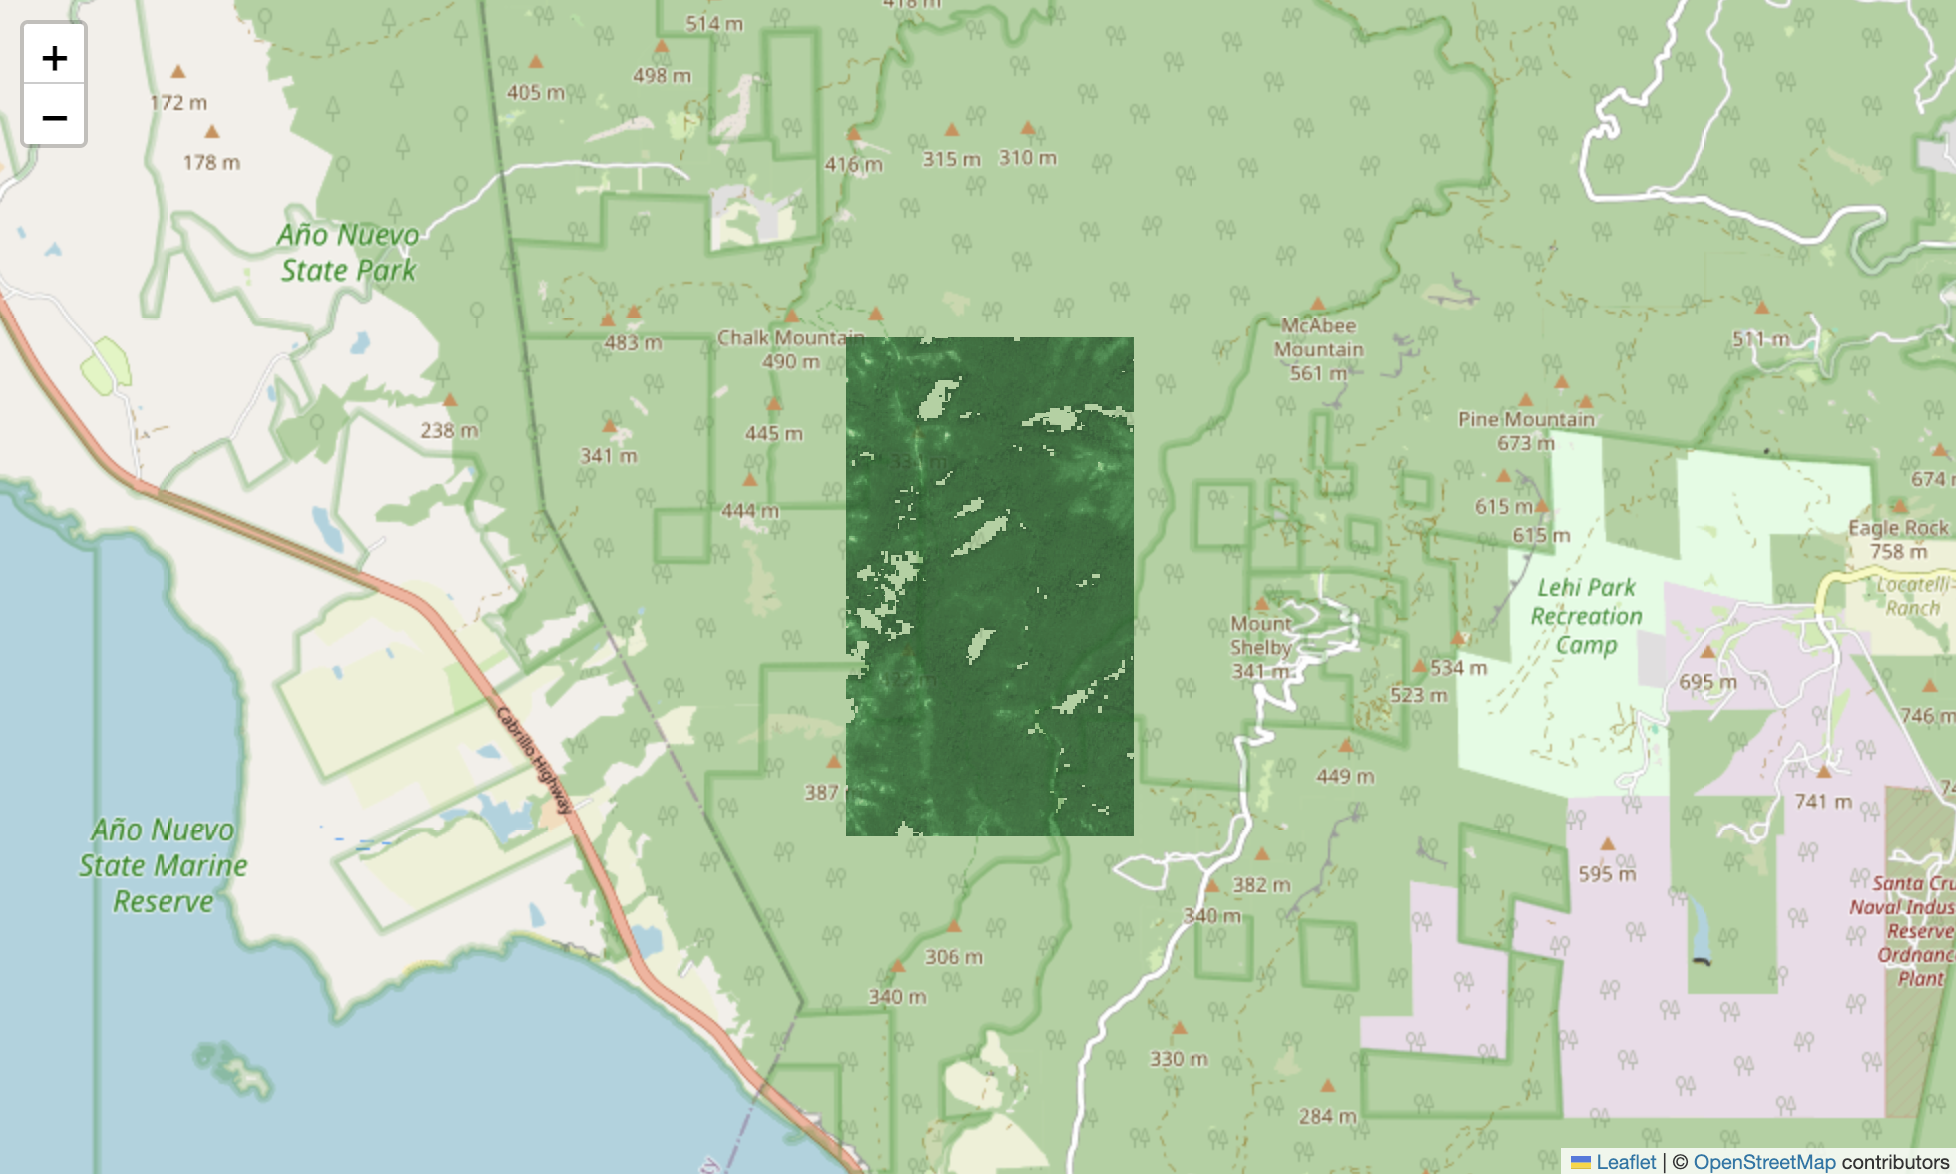

In [82]:
Image("monitor_vegetation_ndvi.png")